## Importing Needed Libraries

Pertama, sejumlah pustaka penting diimpor, seperti:

numpy dan pandas untuk manipulasi data,
seaborn dan matplotlib untuk visualisasi data,
keras untuk membangun dan melatih model LSTM,
sklearn untuk preprocessing data dan evaluasi model.

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

## Reading The Dataset

Dataset yang berisi harga emas diunduh melalui kagglehub dan dimuat ke dalam DataFrame dengan menggunakan pd.read_csv(). Dataset dibaca dengan format tanggal pada kolom Date, dan Date dijadikan sebagai indeks.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sahilwagh/gold-stock-prices")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/sahilwagh/gold-stock-prices/versions/3


In [3]:
import os
path = '../root/.cache/kagglehub/datasets/sahilwagh/gold-stock-prices/versions/3'
# Periksa file yang tersedia di path dataset
print("Files in dataset directory:")
print(os.listdir(path))

Files in dataset directory:
['goldstock v2.csv', 'goldstock v1.csv']


In [4]:
# Pastikan path file benar
correct_path = os.path.join(path, 'goldstock v2.csv')

# Muat dataset
df = pd.read_csv(correct_path, parse_dates=True, index_col='Date')

## Exploring The Dataset

Setelah dataset dimuat, langkah selanjutnya adalah mengeksplorasi isi dataset. Fungsi df.info() memberikan gambaran tentang tipe data dan jumlah nilai yang tidak kosong.

**Menampilkan Informasi Tiap Variabel**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2024-07-03 to 2014-07-07
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  2511 non-null   int64  
 1   Close/Last  2511 non-null   float64
 2   Volume      2511 non-null   float64
 3   Open        2511 non-null   float64
 4   High        2511 non-null   float64
 5   Low         2511 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 137.3 KB


Fungsi df.describe() memberikan deskripsi statistik dari setiap kolom, dan df.

**Menampilkan Deskripsi Statistik**

In [7]:
df.describe()

,Unnamed: 0,Close/Last,Volume,Open,High,Low
count,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000,2511.000000
mean,1259.864596,1541.176902,190261.189168,1541.136041,1551.244843,1530.976344
std,728.488698,333.631989,96871.355690,333.699364,336.375007,330.790580
min,0.000000,1049.600000,1.000000,1051.500000,1062.700000,1045.400000
25%,630.500000,1251.300000,133774.000000,1250.650000,1258.500000,1243.900000
50%,1259.000000,1409.700000,181273.000000,1404.600000,1418.900000,1401.400000
75%,1888.500000,1832.050000,238157.500000,1833.000000,1844.000000,1819.450000
max,2528.000000,2438.500000,787217.000000,2431.500000,2454.200000,2411.100000


corr() digunakan untuk melihat korelasi antar variabel. Kemudian, beberapa visualisasi dibuat menggunakan matplotlib untuk menunjukkan hubungan korelasi tiap variabel.

**Menampilkan korelasi antar variable**

In [8]:
correlation = df.corr()
correlation

,Unnamed: 0,Close/Last,Volume,Open,High,Low
Unnamed: 0,1.000000,-0.914928,-0.056636,-0.914731,-0.913637,-0.916239
Close/Last,-0.914928,1.000000,0.019551,0.999135,0.999589,0.999644
Volume,-0.056636,0.019551,1.000000,0.023158,0.027213,0.015087
Open,-0.914731,0.999135,0.023158,1.000000,0.999544,0.999473
High,-0.913637,0.999589,0.027213,0.999544,1.000000,0.999369
Low,-0.916239,0.999644,0.015087,0.999473,0.999369,1.000000


<Axes: >

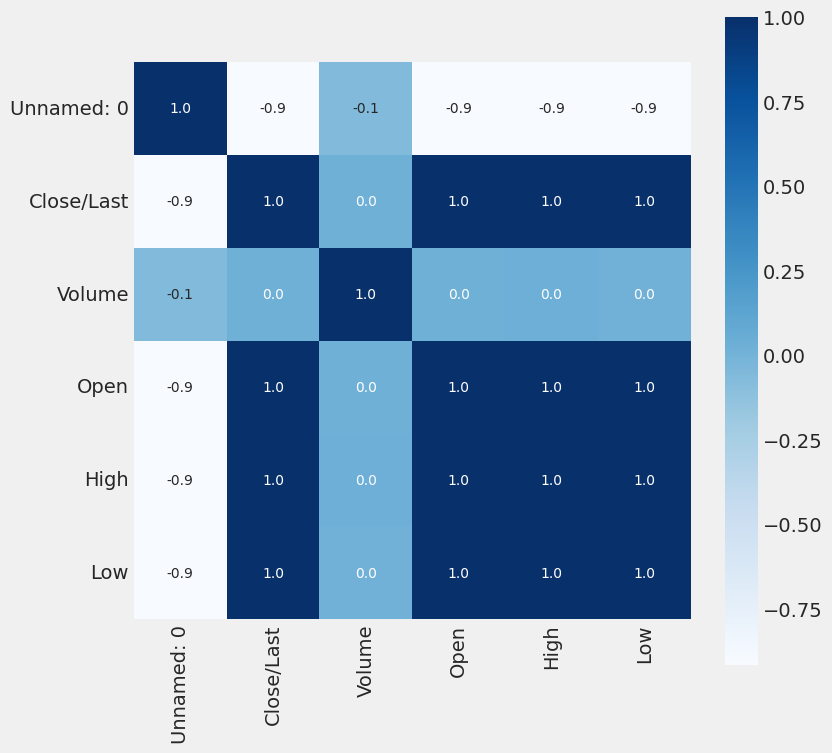

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f',annot=True, annot_kws={'size':10}, cmap='Blues')

Kemudian, beberapa visualisasi lagi dibuat menggunakan matplotlib untuk menunjukkan pola harga buka (Open), harga tutup (Close), volume, serta harga tertinggi dan terendah.

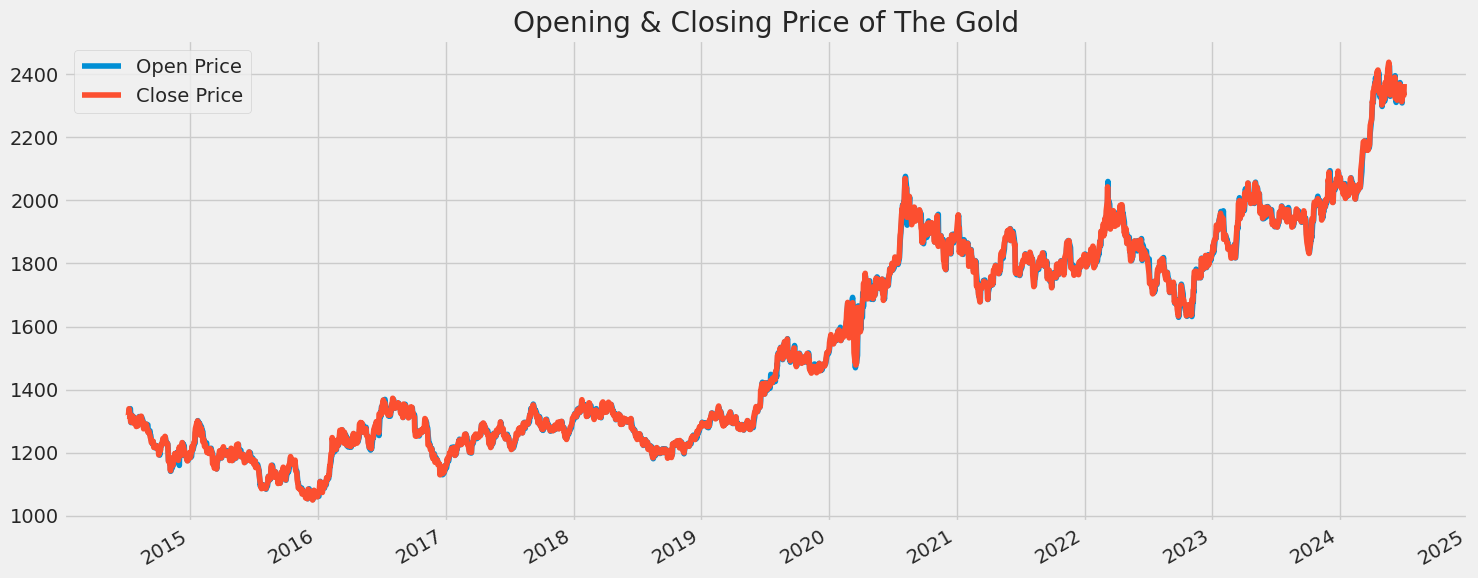

In [9]:
plt.figure(figsize=(15, 6))
df['Open'].plot()
df['Close/Last'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("Opening & Closing Price of The Gold")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

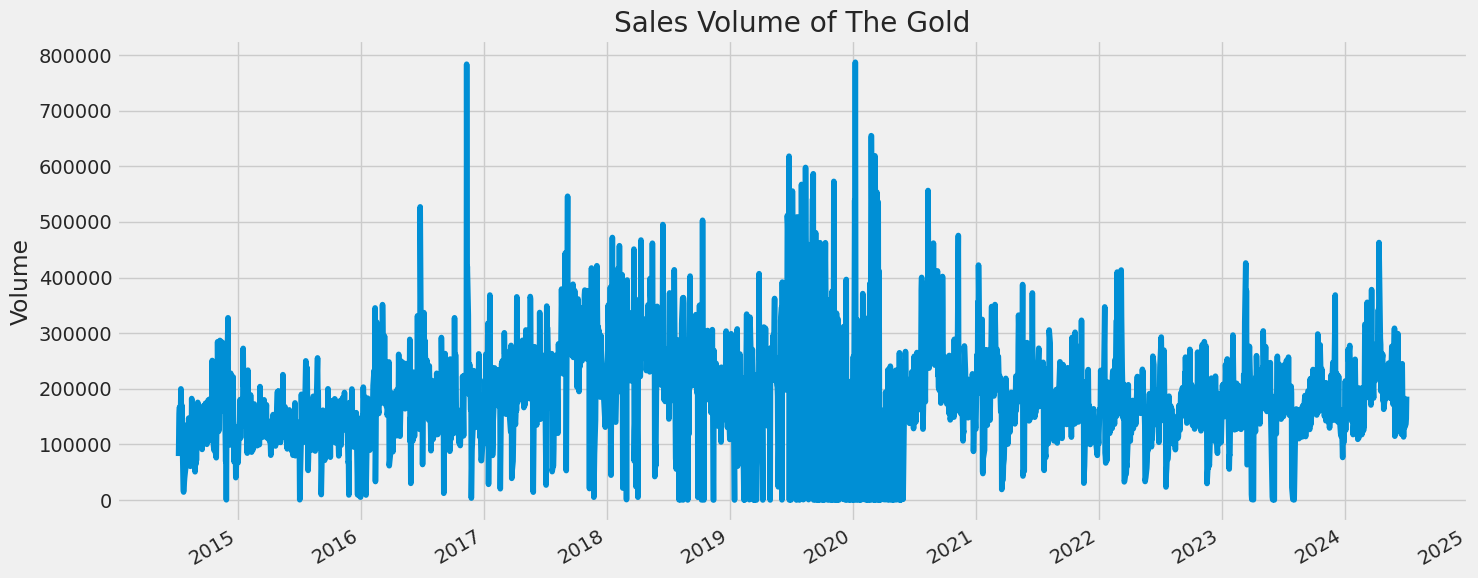

In [10]:
plt.figure(figsize=(15, 6))
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel(None)
plt.title("Sales Volume of The Gold")
plt.tight_layout()
plt.show()

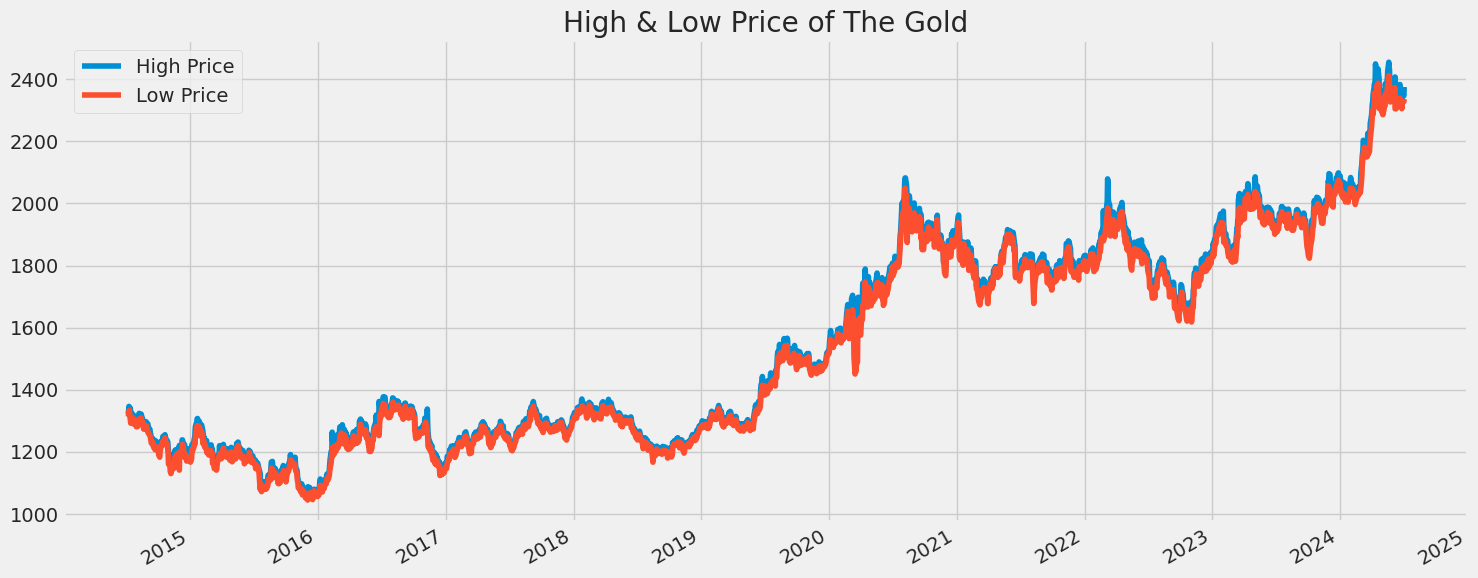

In [11]:
plt.figure(figsize=(15, 6))
df['High'].plot()
df['Low'].plot()
plt.ylabel(None)
plt.xlabel(None)
plt.title("High & Low Price of The Gold")
plt.legend(['High Price', 'Low Price'])
plt.tight_layout()
plt.show()

## Preprocessing The Data

**Choose The Prediction Column**

Memilih Kolom yang Diprediksi: Kolom Close/Last dipilih sebagai target yang ingin diprediksi.

In [12]:
dataset = df['Close/Last']
dataset = pd.DataFrame(dataset)

data = dataset.values

data.shape

(2511, 1)

**Normalizing The Data**

Normalisasi Data: Menggunakan MinMaxScaler dari sklearn untuk merubah skala data menjadi rentang [0, 1], yang penting agar model tidak terpengaruh oleh skala besar data lainnya.

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(data).reshape(-1, 1))

**Splitting The Data**

Membagi Data: Data dibagi menjadi dua bagian, 80% untuk data latih dan 20% untuk data uji.

In [14]:
train_size = int(len(data)*0.8)
test_size = len(data) - train_size

print("Train Size: ", train_size)
print("Test Size: ", test_size)

train_data = scaled_data[:train_size, 0:1]
test_data = scaled_data[train_size-60:, 0:1]

Train Size:  2008
Test Size:  503


In [15]:
print(train_data.shape)
print(test_data.shape)

(2008, 1)
(563, 1)


**Creating The Training Set**

Untuk membangun dataset pelatihan, dibuat data dengan 60 waktu langkah (timesteps) yang digunakan untuk memprediksi harga emas pada waktu berikutnya. Setiap data latih berisi 60 harga sebelumnya, dan targetnya adalah harga setelahnya.

In [16]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [17]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [18]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
print(x_train.shape)
print(y_train.shape)

(1948, 60, 1)
(1948,)


## LSTM Model

**Model Structure**

Model LSTM dibangun menggunakan Sequential dari Keras. Model ini terdiri dari dua layer LSTM, masing-masing dengan 50 dan 64 unit, diikuti oleh beberapa layer Dense untuk menghasilkan output prediksi. Model dikompilasi menggunakan optimizer 'adam' dan loss function 'mse' (Mean Squared Error).

In [20]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics= ["mean_absolute_error"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

**Model Training**

Model dilatih menggunakan data latih yang telah dipersiapkan. Proses pelatihan berlangsung selama 100 epoch, dengan batch size 128, dan menggunakan callback EarlyStopping untuk menghentikan pelatihan jika tidak ada perbaikan dalam 10 epoch berturut-turut.

In [22]:
# Fitting the LSTM to the Training set
callbacks = [EarlyStopping(monitor= 'loss', patience= 10 , restore_best_weights= True)]
history = model.fit(x_train, y_train, epochs= 100, batch_size= 128 , callbacks= callbacks )

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0470 - mean_absolute_error: 0.1651
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 0.0039 - mean_absolute_error: 0.0522
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step - loss: 0.0014 - mean_absolute_error: 0.0287
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 7.0484e-04 - mean_absolute_error: 0.0200
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 5.6952e-04 - mean_absolute_error: 0.0178
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 5.3754e-04 - mean_absolute_error: 0.0175
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 5.6734e-04 - mean_absolute_error: 0.0179
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - loss: 5.3360e-04 - mean_absolute_error: 0.0174
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - loss: 5.5119e-04 - mean_absolute_error: 0.0175
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 5.6169e-04 - mean_absolute_error

**Model Evaluation**

Setelah pelatihan selesai, performa model dievaluasi. Grafik yang menampilkan loss dan mean_absolute_error selama pelatihan digunakan untuk menilai seberapa baik model beradaptasi dengan data.

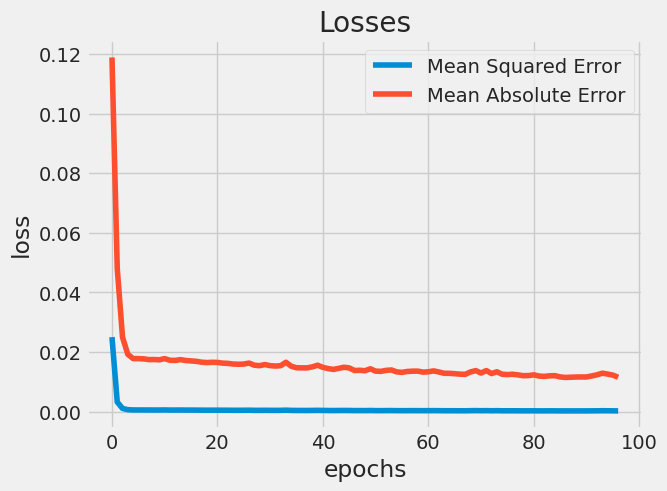

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## Prediction

**Creating Testing Set**

Data uji disiapkan dengan cara yang sama seperti data latih, dengan 60 waktu langkah digunakan untuk memprediksi harga emas pada waktu berikutnya. Setelah model memberikan prediksi, hasilnya dinormalisasi kembali ke skala asli menggunakan scaler yang telah dilatih sebelumnya.

In [24]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
x_test.shape , y_test.shape

((503, 60, 1), (503,))

In [26]:
#inverse y_test scaling
predictions = model.predict(x_test)

#inverse predictions scaling
predictions = scaler.inverse_transform(predictions)
predictions.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


(503, 1)

**Mean Average Error**

Loss: 1.7942e-04
Ini adalah nilai kerugian (loss) yang dihitung dari dataset uji (x_test dan y_test). Nilai loss yang sangat kecil (sekitar 0.00017942) menunjukkan bahwa model memiliki kemampuan yang baik dalam memprediksi harga emas berdasarkan data uji, dengan kesalahan prediksi yang sangat kecil.

Mean Absolute Error (MAE): 0.0108
MAE mengukur rata-rata kesalahan absolut antara nilai sebenarnya (y_test) dan prediksi (y_pred) yang dihasilkan model. Nilai MAE yang rendah (0.0108) menunjukkan bahwa prediksi harga emas model sangat mendekati nilai sebenarnya dalam skala data yang digunakan.

In [27]:
result = model.evaluate( x_test, y_test)
y_pred = model.predict(x_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7942e-04 - mean_absolute_error: 0.0108
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


**Visualizing Predictions with The Data**

Hasil prediksi dibandingkan dengan data aktual (harga emas yang sebenarnya) dan divisualisasikan. Grafik ini menunjukkan perbandingan antara harga yang diprediksi dan harga yang sebenarnya selama periode pengujian.

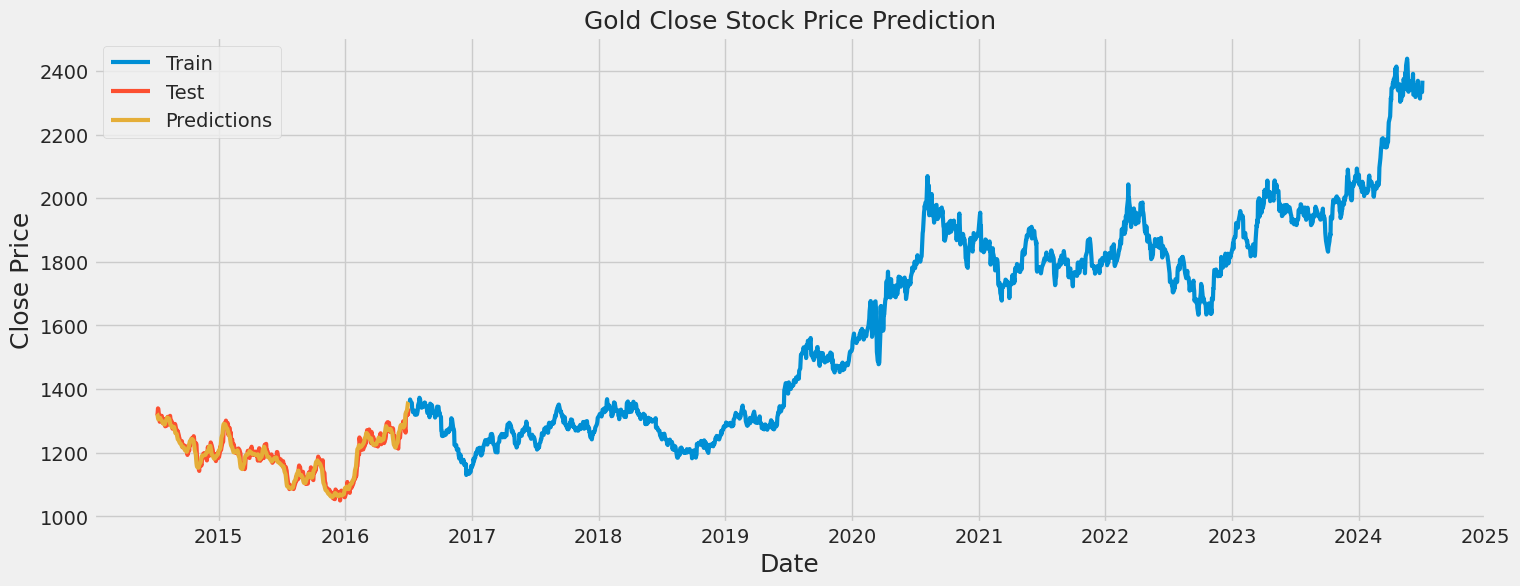

In [28]:
train = dataset.iloc[:train_size , 0:1]
test = dataset.iloc[train_size: , 0:1]
test['Predictions'] = predictions

plt.figure(figsize= (16, 6))
plt.title('Gold Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)
plt.plot(train['Close/Last'], linewidth= 3)
plt.plot(test['Close/Last'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)
plt.legend(['Train', 'Test', 'Predictions'])
plt.show()